## Air Quality - Madrid (2001 - 2017)

Time series and prediction for the years 2018 and 2019

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

### Load and merge data (2001 to 2017). 

Not all dataframes have the same structure, I use pd.concat with axis=0 to end up with a dataframe containing all the columns from all the csv's files. NaN added for missing values.

In [2]:
df = pd.read_csv('data\csvs_per_year\madrid_2001.csv')

for year in range(2002, 2018):
    df_temp = pd.read_csv(f'data\csvs_per_year\madrid_{year}.csv')
    df = pd.concat([df, df_temp], axis = 0)

In [3]:
df.head() 

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
0,2001-08-01 01:00:00,NaN,0.37,NaN,NaN,NaN,58.400002,87.150002,NaN,34.529999,105.000000,NaN,6.34,NaN,NaN,28079001,NaN,NaN,NaN
1,2001-08-01 01:00:00,1.5,0.34,1.49,4.1,0.07,56.250000,75.169998,2.11,42.160000,100.599998,1.73,8.11,1.24,10.82,28079035,NaN,NaN,NaN
2,2001-08-01 01:00:00,NaN,0.28,NaN,NaN,NaN,50.660000,61.380001,NaN,46.310001,100.099998,NaN,7.85,NaN,NaN,28079003,NaN,NaN,NaN
3,2001-08-01 01:00:00,NaN,0.47,NaN,NaN,NaN,69.790001,73.449997,NaN,40.650002,69.779999,NaN,6.46,NaN,NaN,28079004,NaN,NaN,NaN
4,2001-08-01 01:00:00,NaN,0.39,NaN,NaN,NaN,22.830000,24.799999,NaN,66.309998,75.180000,NaN,8.80,NaN,NaN,28079039,NaN,NaN,NaN


In [4]:
df.tail()

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
210115,2017-08-01 00:00:00,NaN,0.2,NaN,NaN,NaN,27.0,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,28079056,NaN,1.0,NaN
210116,2017-08-01 00:00:00,NaN,0.2,NaN,NaN,NaN,14.0,NaN,NaN,NaN,73.0,NaN,7.0,NaN,NaN,28079057,NaN,1.0,NaN
210117,2017-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN,28079058,NaN,1.0,NaN
210118,2017-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,28079059,NaN,1.0,NaN
210119,2017-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,77.0,60.0,NaN,NaN,NaN,NaN,28079060,NaN,1.0,NaN


### Sort by dates

In [5]:
# convert date column from object to datetime type
df['date'] = pd.to_datetime(df.date)

# sort by date
df.sort_values(by=['date'], inplace=True, ascending=True)

### NaN values

In [6]:
# percentage of NaN values per column
df_nan = df.isna().mean().round(4) * 100
df_nan

date        0.00
BEN        72.59
CO         29.87
EBE        73.66
MXY        91.56
NMHC       71.20
NO_2        0.56
NOx        38.29
OXY        91.56
O_3        21.06
PM10       24.47
PXY        91.56
SO_2       26.52
TCH        71.17
TOL        72.67
station     0.00
PM25       78.67
NO         60.86
CH4        99.83
dtype: float64

From here it can be seen that MXY, OXY, PXY and CH4 are more than 90% NaN values. Also, BEN, EBE, NMHC, TCH, TOL and PM25 are more than 70% NaN values. Not much information will be drown from these pollutants. 

In this analysis I will look at NO2, O3, PM10 and SO2. In https://www.londonair.org.uk/LondonAir/nowcast.aspx only NO2, O3, PM10 and PM25 are reported.


In [7]:
df_2=df.drop(columns=['NO', 'BEN', 'EBE', 'MXY', 'NMHC', 'OXY', 'PXY', 'TCH', 'TOL', 'CH4', 'PM25','NOx', 'station'])
df_2.head()

,date,CO,NO_2,O_3,PM10,SO_2
108377,2001-01-01 01:00:00,1.45,50.389999,4.180000,21.219999,10.86
108384,2001-01-01 01:00:00,1.25,55.290001,7.830000,30.559999,22.10
108383,2001-01-01 01:00:00,0.87,53.400002,8.350000,36.669998,11.42
108382,2001-01-01 01:00:00,0.79,47.320000,3.400000,14.440000,9.69
108381,2001-01-01 01:00:00,0.67,43.820000,32.490002,11.890000,9.35


In [8]:
pollutants_nan_percentage = df_2.isna().mean().drop(labels=['date']).round(4)*100

<AxesSubplot:title={'center':'Percentage of NaN values'}, xlabel='Pollutant', ylabel='NaN percentage (%)'>

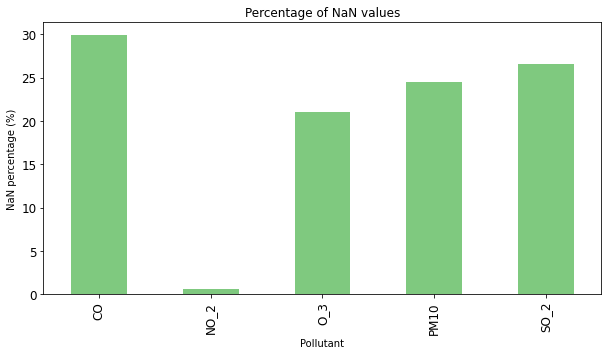

In [9]:
plt.figure(figsize=(10, 5))
pollutants_nan_percentage.plot(
    xlabel='Pollutant', 
    ylabel='NaN percentage (%)', 
    kind='bar', 
    title='Percentage of NaN values',
    fontsize = 12,
    colormap = 'Accent'
)


### Summary

In [10]:
df_2.describe().round(2)

,CO,NO_2,O_3,PM10,SO_2
count,2622414.00,3718224.00,2951683.00,2824344.00,2747374.00
mean,0.55,50.69,39.76,29.14,10.71
std,0.54,34.62,30.41,26.02,9.14
min,0.00,0.00,0.00,0.00,0.00
25%,0.26,24.00,12.65,11.75,5.90
50%,0.40,44.32,34.66,21.75,8.20
75%,0.65,69.90,59.74,38.00,12.36
max,18.04,628.60,236.00,695.00,199.10


There is a huge difference between Median and Maximum values. There must be outliers present. 

### Further data exploration

How widely is the data distributed?

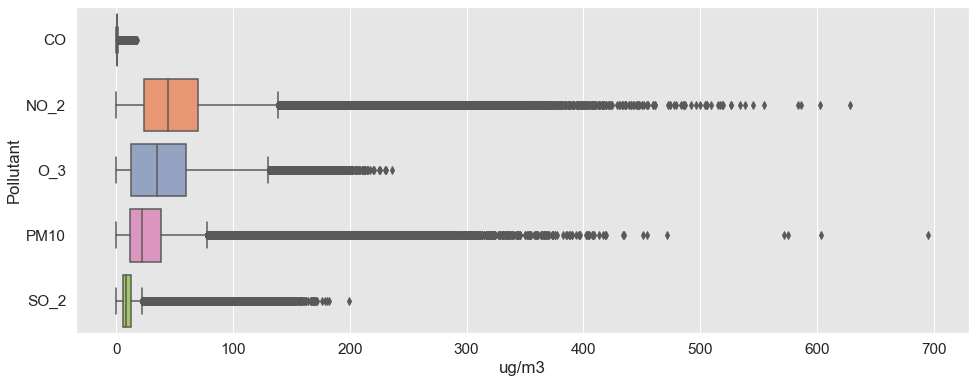

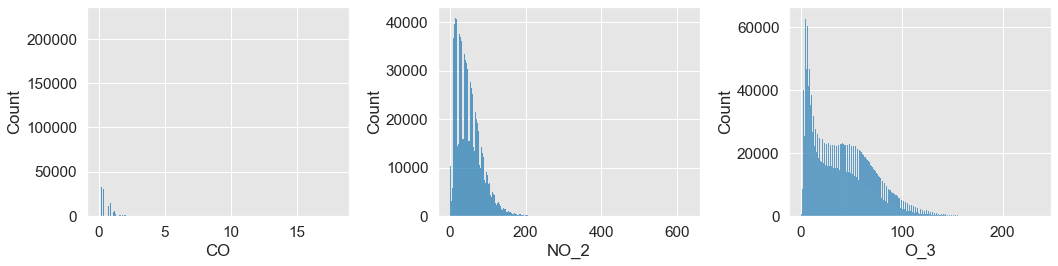

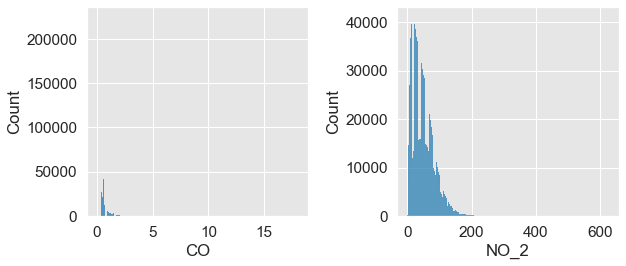

In [11]:
plt.figure(figsize=(16, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.4)
plt.ylabel('Pollutant')
plt.xlabel('ug/m3')
ax = sns.boxplot(data=df_2, orient="h", palette="Set2")

fig, axs = plt.subplots(ncols=3,figsize=(15, 4))
sns.histplot(df_2, x="CO", ax=axs[0])
sns.histplot(df_2, x="NO_2",ax=axs[1])
sns.histplot(df_2, x="O_3",ax=axs[2])
plt.tight_layout()

fig, axs = plt.subplots(ncols=2,figsize=(9, 4))
sns.histplot(df_2, x="CO", ax=axs[0])
sns.histplot(df_2, x="NO_2",ax=axs[1])
plt.tight_layout()

From above, we find that there are too many high unexpected values. This is conditional to the inherent events within the city, where dense air pollution might have occured due to heavy traffic from huge number of vehicles.

Looking at maximum values per day

<AxesSubplot:xlabel='SO_2', ylabel='Count'>

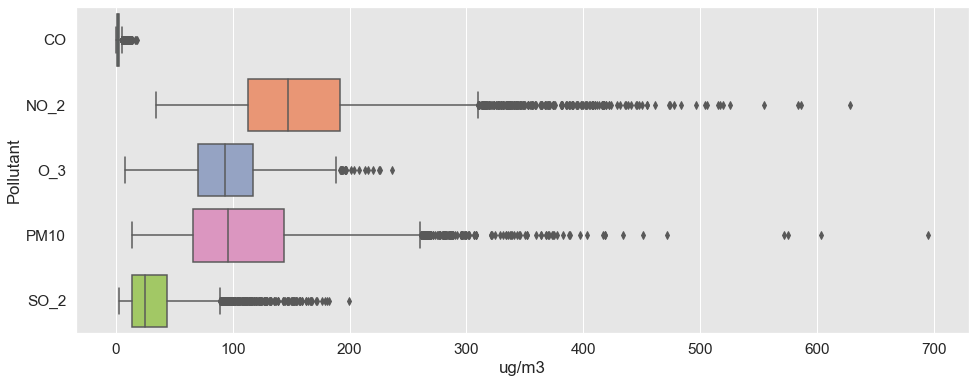

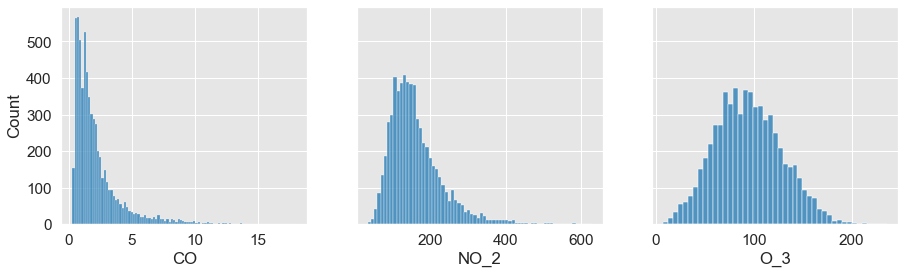

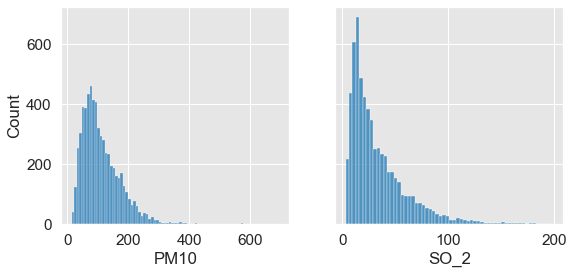

In [12]:
df_max_day = df_2.groupby(by=df_2['date'].dt.date).max()

plt.figure(figsize=(16, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.4)
plt.ylabel('Pollutant')
plt.xlabel('ug/m3')
ax = sns.boxplot(data=df_max_day, orient="h", palette="Set2")

fig, axs = plt.subplots(ncols=3,figsize=(15, 4), sharey=True)
sns.histplot(df_max_day, x="CO", ax=axs[0])
sns.histplot(df_max_day, x="NO_2",ax=axs[1])
sns.histplot(df_max_day, x="O_3",ax=axs[2])

fig, axs = plt.subplots(ncols=2,figsize=(9, 4), sharey=True)
sns.histplot(df_max_day, x="PM10", ax=axs[0])
sns.histplot(df_max_day, x="SO_2",ax=axs[1])

After aggregating, it is shown that the plots are bit more normalized in comparison to the previous ones, but still we find some outliers in this case.

In [13]:
# Monthly average - maximum value per day
df_monthAvg = df_2.groupby(by=df_2['date'].dt.to_period("M")).mean()
df_monthAvg.head()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2001-01,1.158651,57.060443,19.503658,29.483590,24.999726
2001-02,1.232021,64.685852,20.524997,37.242604,29.107004
2001-03,0.835143,49.467733,29.011205,25.040909,18.514023
2001-04,0.683786,53.116105,40.434246,25.705201,15.146620
2001-05,0.773319,64.069870,41.042910,28.819509,14.720223


In [14]:
df_monthAvg.tail()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2017-09,0.325573,39.925243,51.713658,16.847448,6.920447
2017-10,0.387327,53.034415,33.583704,20.202643,5.063458
2017-11,0.512131,62.454503,21.465302,20.317173,8.066219
2017-12,0.459968,53.367710,23.294254,15.935353,7.341961
2018-01,0.230000,9.708333,69.428571,5.583333,4.200000


### Series of the pollutants from Jan 2001 to Dec 2017

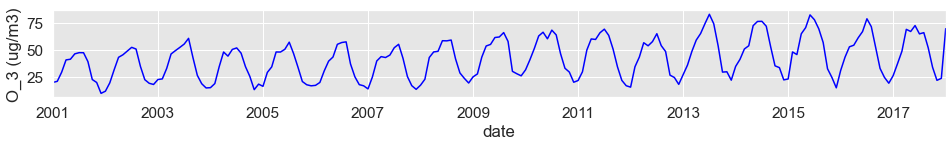

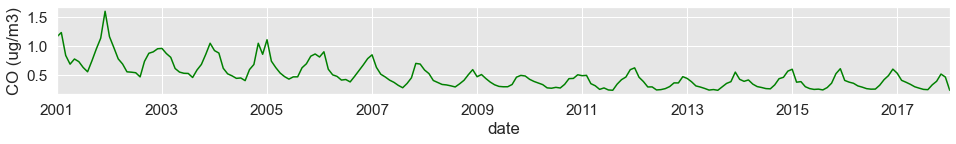

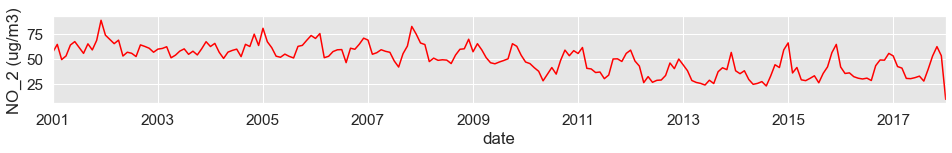

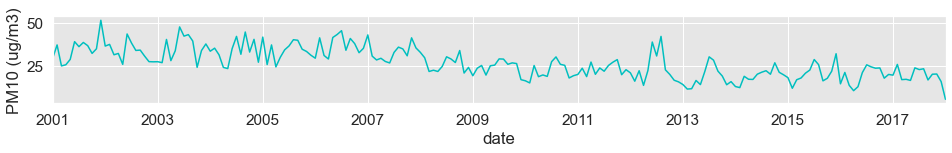

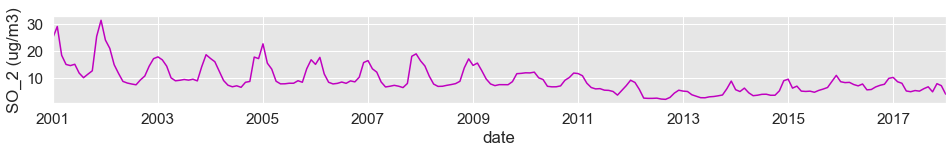

In [15]:
pollutants = ['O_3', 'CO', 'NO_2', 'PM10', 'SO_2']
colors = ['b', 'g', 'r', 'c', 'm']

for pollutant, color in zip(pollutants, colors):
    plt.figure(figsize=(16, 1.6))
    ax = df_monthAvg[pollutant].plot(color=color, y=pollutant)
    ax.set_ylabel(pollutant+' (ug/m3)')

### The combined effect of the pollutants
#### 1. Yearly moving average of the sum of the 5 pollutants

In [16]:
df_yearAvg = df_2.groupby(by=df_2['date'].dt.year).mean()
# drop 2018-01-01 00:00:000 readings, and sum all pollutants
df_yearAvg = df_yearAvg[:-1].sum(axis=1).to_frame()
df_yearAvg.rename(columns={df_yearAvg.columns[0]:'Avg_total_pollution'}, inplace=True)

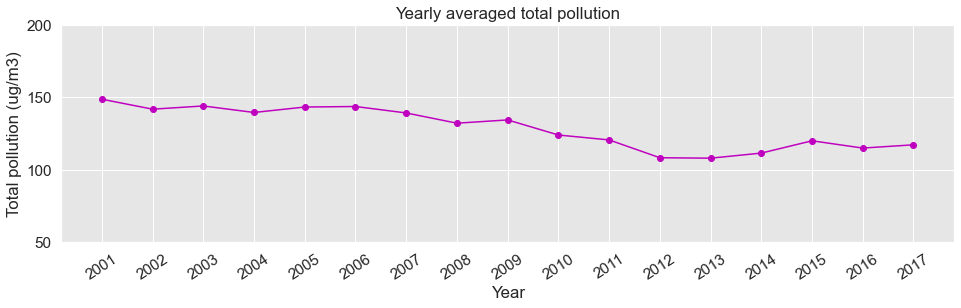

In [17]:
ax = df_yearAvg.plot(
        figsize=(16,4),
        linestyle='-', 
        marker='o', 
        title='Yearly averaged total pollution',
        legend=False,
        xticks=range(2001,2018), 
        yticks=range(50,250,50),
        color='m', rot=33
    )

ax.set_ylabel('Total pollution (ug/m3)')
ax.set_xlabel('Year')
plt.show()

#### 2. Monthly average over the years

In [18]:
df_monthAvg = df_2.groupby(by=df_2['date'].dt.month).mean()
df_monthAvg = df_monthAvg.sum(axis=1).to_frame()
df_monthAvg.rename(columns={df_monthAvg.columns[0]:'Avg_total_pollution'}, inplace=True)

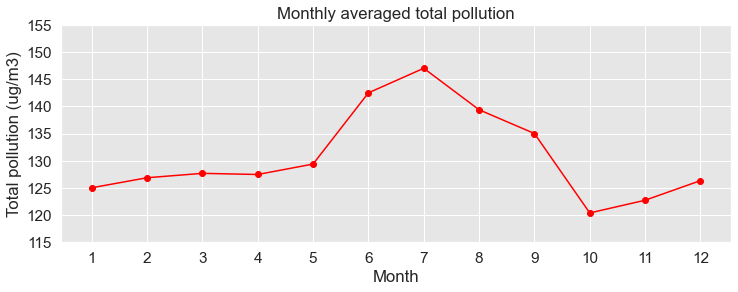

In [19]:
ax = df_monthAvg.plot(
        figsize=(12,4),
        linestyle='-', 
        marker='o', 
        title='Monthly averaged total pollution',
        legend=False,
        yticks=range(115,160,5),
        xticks=range(1,13),
        color='r'
    )

ax.set_ylabel('Total pollution (ug/m3)')
ax.set_xlabel('Month')
plt.show()

There is a spike of pollution between May and October, getting to a maximum in July.

#### 3. Hourly average over the years

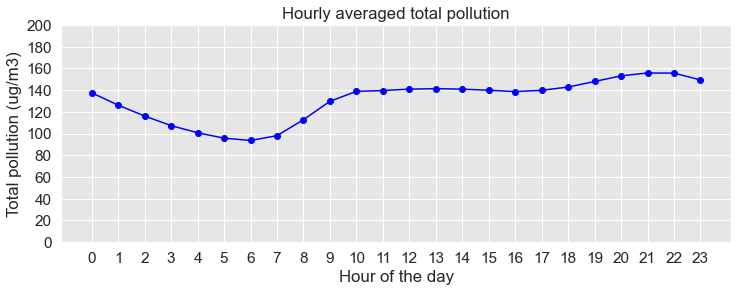

In [49]:
df_hourAvg = df_2.groupby(by=df_2['date'].dt.hour).mean()
df_hourAvg = df_hourAvg.sum(axis=1).to_frame()
df_hourAvg.rename(columns={df_hourAvg.columns[0]:'Avg_total_pollution'}, inplace=True)

ax = df_hourAvg.plot(
        figsize=(12,4),
        linestyle='-', 
        marker='o', 
        title='Hourly averaged total pollution',
        legend=False,
        yticks=range(0,210,20),
        xticks=range(24),
        color='b'
    )

ax.set_ylabel('Total pollution (ug/m3)')
ax.set_xlabel('Hour of the day')
plt.show()